In [ ]:
import multiprocessing
import os
# Get total CPU threads
total_threads = multiprocessing.cpu_count()

# Allocate 2 threads
os.environ['OMP_NUM_THREADS'] = str(min(2, total_threads))
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import cv2
import numpy as np
from matplotlib import pyplot as plt
from core.image_processing import crop_plate, convert_bboxes_to_original, detect_splitting_line
from core.detect_colony_lines import remove_label, find_colonies, detect_colony_lines
from core.count_colony import colony_counting

ModuleNotFoundError: No module named 'core'

(np.float64(-0.5), np.float64(987.5), np.float64(987.5), np.float64(-0.5))

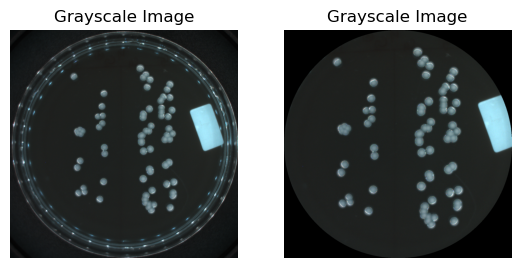

In [ ]:
# Load image
img_path = "top_light/SAMPLE 1/T1/T1-B1.bmp"

#img_path = "data/20March25/sample 1/T2/D.bmp"
img_org = cv2.imread(img_path)

img_cropped, cropped_radius = crop_plate(img_org)

plt.figure(figsize = (10,10))

plt.subplot(1, 3, 1)
plt.imshow(img_org, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_cropped, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")


c:\Users\vinhc\AppData\Local\anaconda3\envs\colony_counter\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\vinhc\AppData\Local\anaconda3\envs\colony_counter\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\vinhc\AppData\Local\anaconda3\envs\colony_counter\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserW

(np.float64(-0.5), np.float64(987.5), np.float64(987.5), np.float64(-0.5))

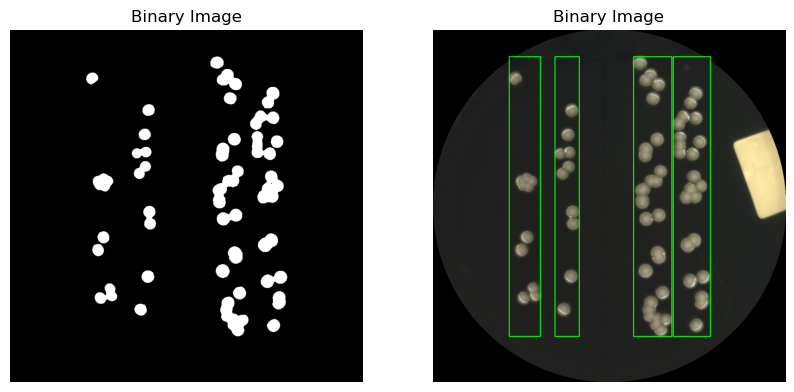

In [3]:
img_bin = remove_label(img_cropped)
centroids_colony = find_colonies(img_cropped)
lines_coords = detect_colony_lines(centroids_colony)

img_show = img_cropped.copy()

for coords in lines_coords:
    if len(coords) == 4:
        x1, y1, x2, y2 = coords
        cv2.rectangle(img_show, (x1,y1), (x2,y2), (0,255,0), 2)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(img_bin,cmap="gray")
plt.title("Binary Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title("Binary Image")
plt.axis("off")

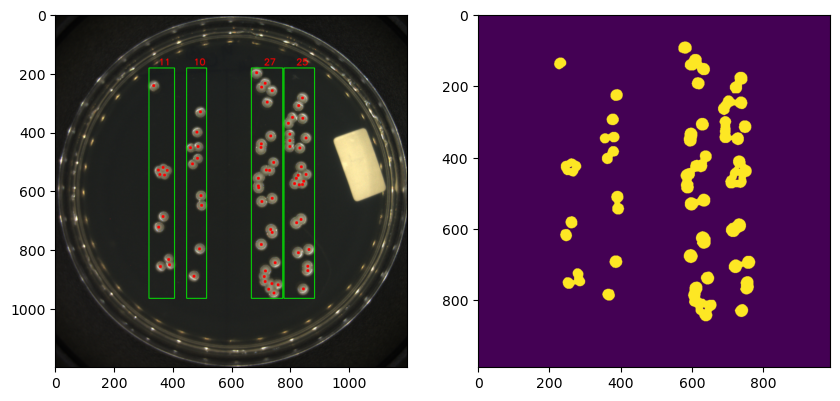

In [4]:
lam = 38
d_t = 0.5
min_radius = 0

list_centroids = []
number_colony = []

list_lines_coords_org = convert_bboxes_to_original(lines_coords,img_org.shape[:2],cropped_radius, bbox_type= "rect")

img_bin_new = detect_splitting_line(img_bin)

for i, (x_min, y_min, x_max, y_max) in enumerate(lines_coords):

    img_line_bin = img_bin_new[y_min:y_max, x_min:x_max]
    
    counting_result, centroids = colony_counting(img_line_bin, lam, d_t, min_radius)

    number_colony.append(counting_result)

    centroids_org = convert_bboxes_to_original(centroids,img_cropped.shape[:2],(x_min, y_min, x_max, y_max), bbox_type = "circle")
    list_centroids.extend(centroids_org)
    

img_show = img_org.copy()

list_centroids_org = convert_bboxes_to_original(list_centroids,img_org.shape[:2],cropped_radius,bbox_type = "circle")

for i, coords in enumerate(list_lines_coords_org):
    x1, y1, x2, y2 = coords
    text_position = (int((x2 + x1)/2-10), y1 - 10)
    cv2.putText(img_show, str(number_colony[i]), text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255),2, cv2.LINE_AA)
    cv2.rectangle(img_show, (x1,y1), (x2,y2), (0,255,0), 2)

for coords in list_centroids_org:
    center_x_orig, center_y_orig, radius_orig = coords
    cv2.circle(img_show, (int(center_x_orig), int(center_y_orig)), 0, (0,0,255), 10)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(img_bin_new)